Dataset: https://www.kaggle.com/datasets/puneetbhaya/online-retail 1. Do customer segmentation/ clustering (you can get help from 2nd link in self-study) 2. Describe each group's behaviors

In [152]:
#importing libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette("flare")
sns.set_style('darkgrid')
import datetime
import math

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

In [155]:
df = pd.read_excel('data/Online Retail.xlsx')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [157]:
df.describe().T

count          mean          std       min       25%       50%  \
Quantity    541909.0      9.552250   218.081158 -80995.00      1.00      3.00   
UnitPrice   541909.0      4.611114    96.759853 -11062.06      1.25      2.08   
CustomerID  406829.0  15287.690570  1713.600303  12346.00  13953.00  15152.00   

                 75%      max  
Quantity       10.00  80995.0  
UnitPrice       4.13  38970.0  
CustomerID  16791.00  18287.0

In [158]:
print('Duplicated Data')
df.duplicated().sum()

Duplicated Data


5268

In [159]:
print('negative quantity and prices at same register:',
     'No' if df[(df.Quantity<0) & (df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')

print('quantity is negative',
      'and prices is 0 or vice-versa:', 
      df[(df.Quantity<=0) & (df.UnitPrice<=0)].shape[0])

print('\n customer ID of the registers above:',
      df.loc[(df.Quantity<=0) & (df.UnitPrice<=0), 
                ['CustomerID']].CustomerID.unique())

print('\n% Negative Quantity: {:3.2%}'.format(df[(df.Quantity<0)].shape[0]/df.shape[0]))

print('\nAll register with negative quantity has Invoice start with:', 
      df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print('\nSee an example of negative quantity and others related records:')
display(df[(df.CustomerID==12472) & (df.StockCode==22244)])

negative quantity and prices at same register: No 

quantity is negative and prices is 0 or vice-versa: 1336

 customer ID of the registers above: [nan]

% Negative Quantity: 1.96%

All register with negative quantity has Invoice start with: ['C']

See an example of negative quantity and others related records:


InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice  CustomerID  Country  
1973   2010-12-01 14:33:00       1.95     12472.0  Germany  
9438   2010-12-05 14:19:00       1.95     12472.0  Germany  
121980 2011-03-17 12:40:00       1.95     12472.0  Germany

In [160]:
print('Check register with UnitPrice negative:')
display(df[(df.UnitPrice<0)])
print("Sales records with Customer ID and zero in Unit Price:",df[(df.UnitPrice==0) 
                                                                     & ~(df.CustomerID.isnull())].shape[0])
df[(df.UnitPrice==0)  & ~(df.CustomerID.isnull())]

Check register with UnitPrice negative:


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Sales records with Customer ID and zero in Unit Price: 40


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
157042 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
187613 2011-05-12 15:21:00       

As you can see, there are no records where quantity and price are negative, but there are 1336 records where one of them is and the other is 0. However, note that for all these records we do not have the customer ID. So we conclude that we can erase all records in that quantity or the price and negative. In addition, by the foregoing summary we see that there are 135,080 records without customer identification that we may also disregar

In [161]:
# Remove register without CustomerID
df = df[~(df.CustomerID.isnull())]

# Remove negative or return transactions
df = df[~(df.Quantity<0)]
df = df[~(df.UnitPrice<0)]

df.describe()
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[397924 rows x 8 columns]

In [162]:
cat_des_df = df.groupby(["StockCode","Description"]).count().reset_index()
cat_des_df

StockCode                   Description  InvoiceNo  Quantity  \
0        10002   INFLATABLE POLITICAL GLOBE          49        49   
1        10080      GROOVY CACTUS INFLATABLE         21        21   
2        10120                  DOGGY RUBBER         30        30   
3        10125       MINI FUNKY DESIGN TAPES         64        64   
4        10133  COLOURING PENCILS BROWN TUBE        124       124   
...        ...                           ...        ...       ...   
3892        C2                      CARRIAGE        133       133   
3893       DOT                DOTCOM POSTAGE         16        16   
3894         M                        Manual        290       290   
3895      PADS    PADS TO MATCH ALL CUSHIONS          4         4   
3896      POST                       POSTAGE       1099      1099   

      InvoiceDate  UnitPrice  CustomerID  Country  
0              49         49          49       49  
1              21         21          21       21  
2              30         30          30       30  
3              64         64          64       64  
4             124        124         124      124  
...           ...        ...         ...      ...  
3892          133        133         133      133  
3893           16         16          16       16  
3894          290        290         290      290  
3895            4          4           4        4  
3896         1099       1099        1099     1099  

[3897 rows x 8 columns]

In [163]:
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head())

df[df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

index  StockCode
0   23196          4
1   23236          4
2   23203          3
3  17107D          3
4   23535          3

array(['BICYCLE SAFTEY WALL ART', 'WALL ART BICYCLE SAFTEY ',
       'WALL ART BICYCLE SAFETY'], dtype=object)

**Mispelling or different description for same item decrease the data quality"**

In [164]:
# First, compute the unique descriptions for each StockCode
unique_desc = df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)

# Then, perform the SQL join using pandas and numpy functions
merged_df = pd.merge(df, unique_desc, on="StockCode")
merged_df = merged_df.drop_duplicates(subset=["InvoiceNo", "StockCode"])

# Select the desired columns
selected_cols = ["InvoiceNo", "StockCode", "Description_y", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"]
final_df = merged_df[selected_cols].rename(columns={"Description_y": "Description"})

df=final_df.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387875 entries, 0 to 397923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387875 non-null  object        
 1   StockCode    387875 non-null  object        
 2   Description  387875 non-null  object        
 3   Quantity     387875 non-null  int64         
 4   InvoiceDate  387875 non-null  datetime64[ns]
 5   UnitPrice    387875 non-null  float64       
 6   CustomerID   387875 non-null  float64       
 7   Country      387875 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 26.6+ MB


In [165]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df['amount'] = df.Quantity*df.UnitPrice
df.CustomerID = df.CustomerID.astype('Int64')

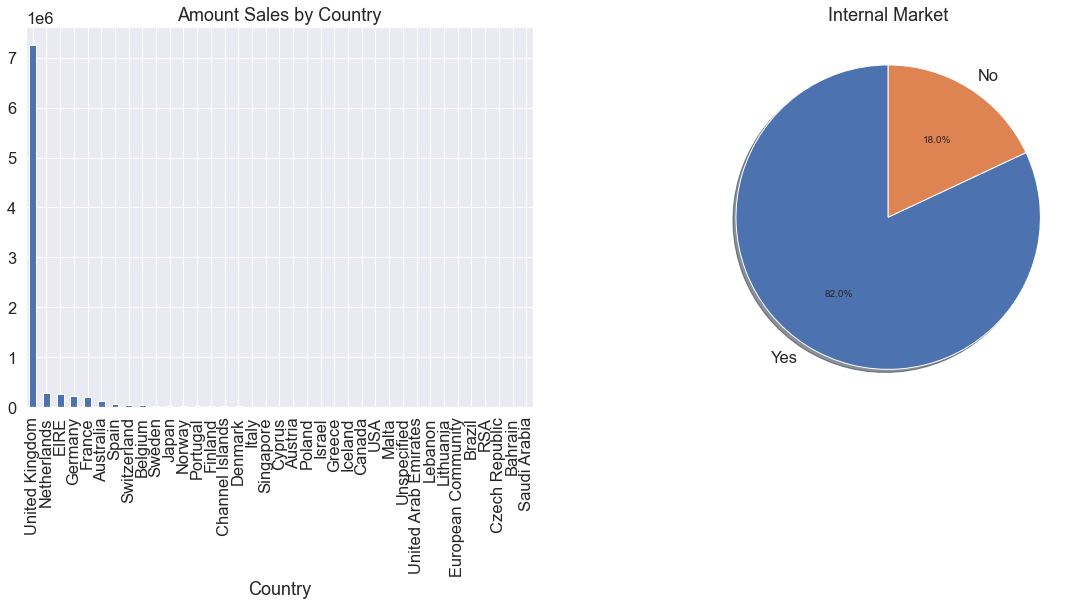

In [166]:
fig = plt.figure(figsize=(20, 7))
f1 = fig.add_subplot(121)
g = df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
df['Internal'] = df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

**We can see that internal marke value is very high especially the UK market**

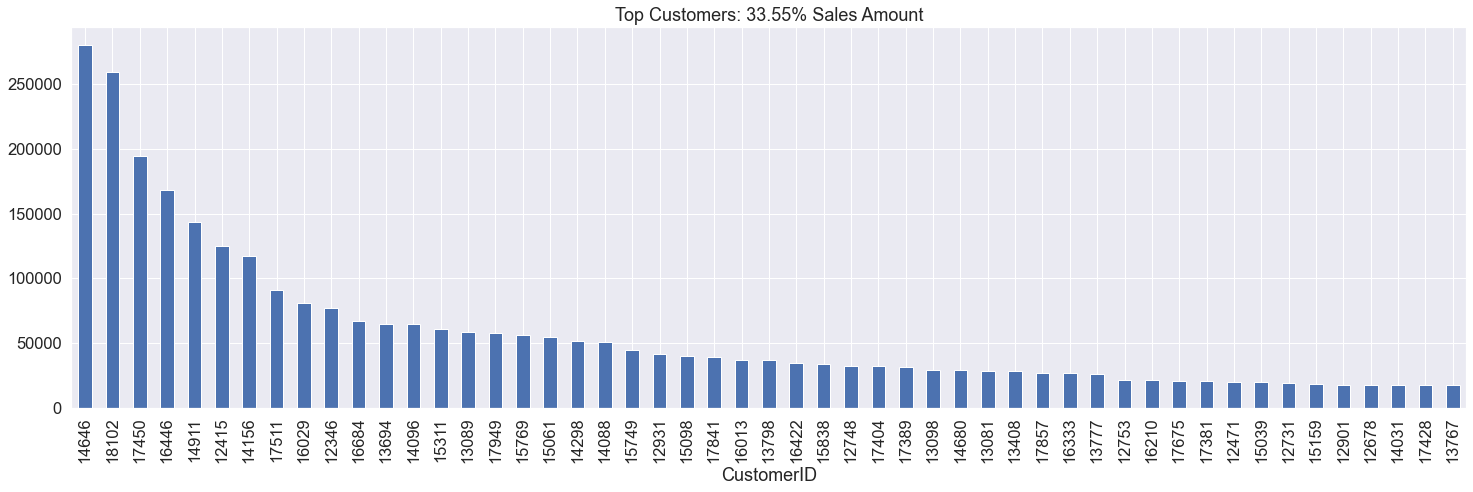

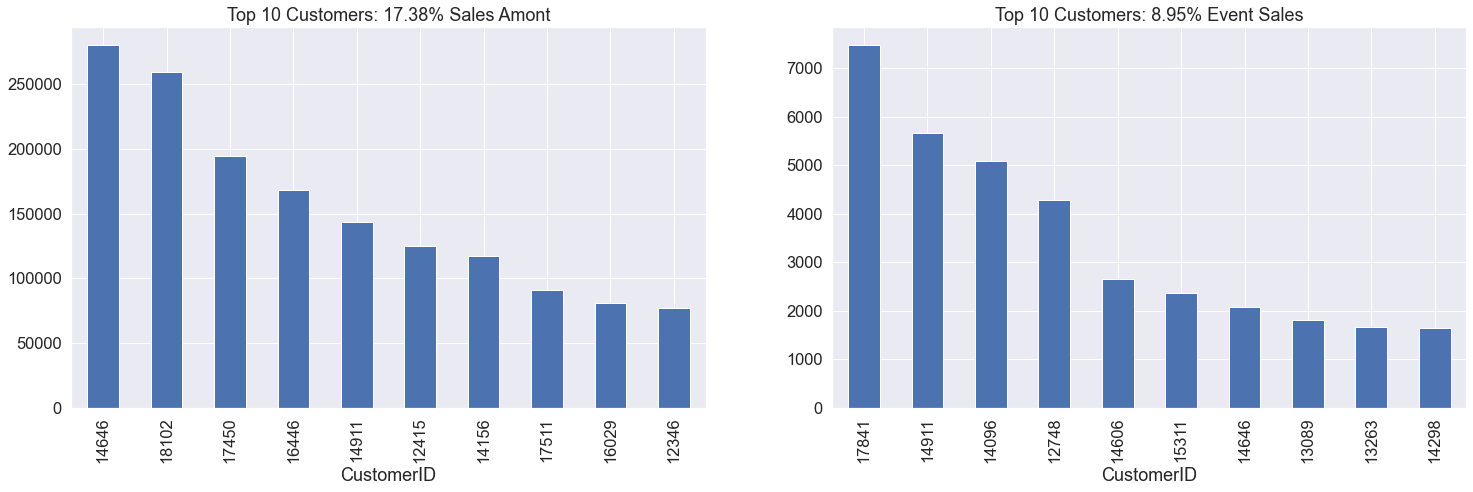

In [167]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))
                                                                            

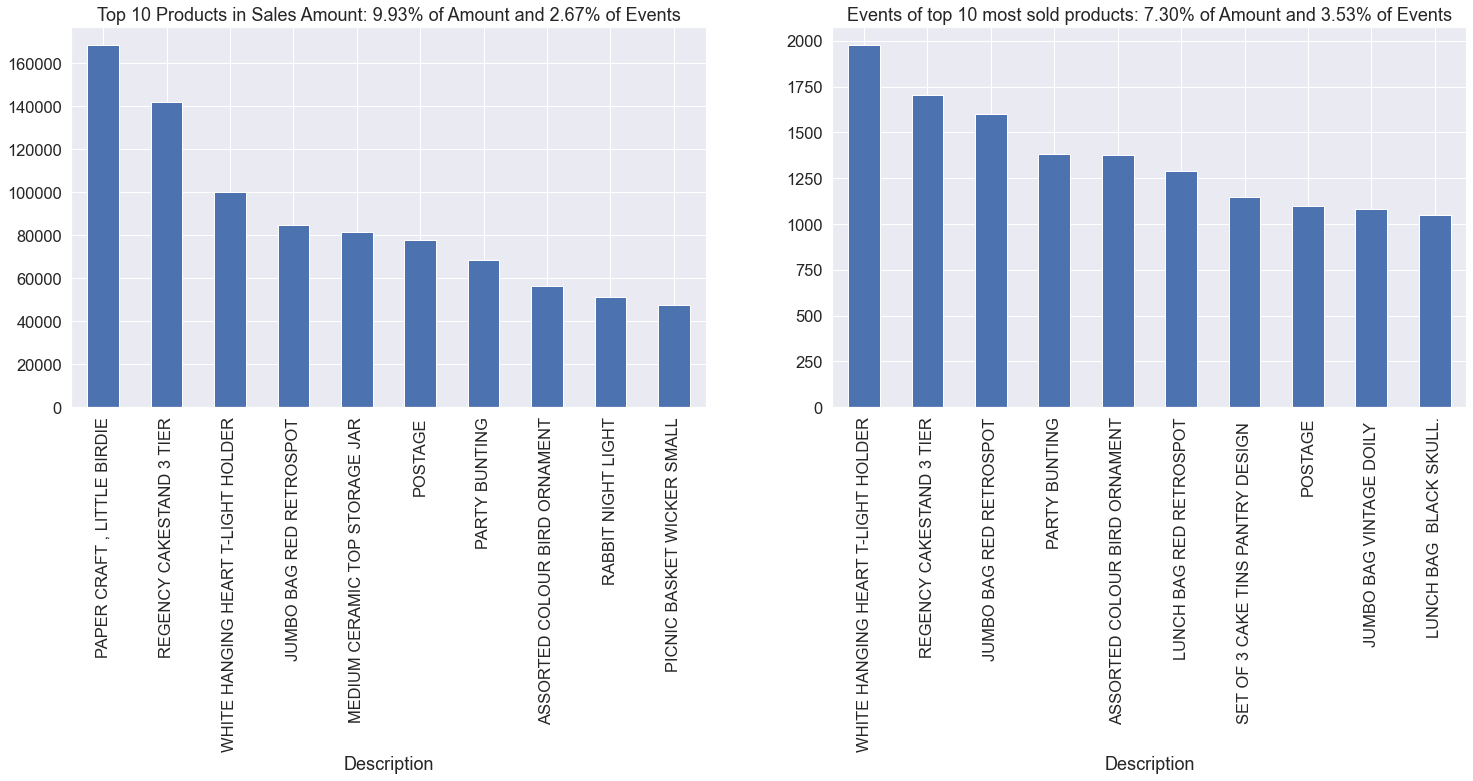

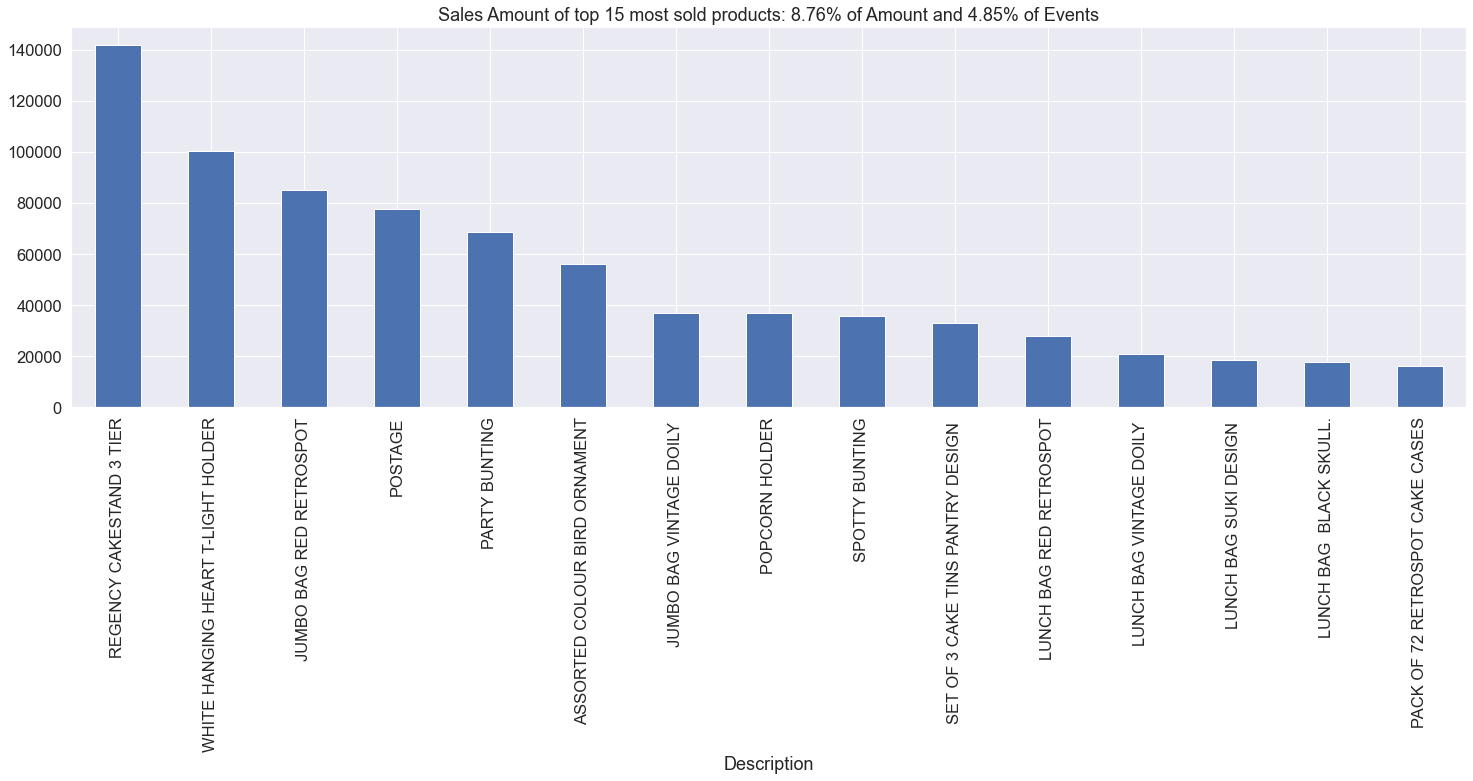

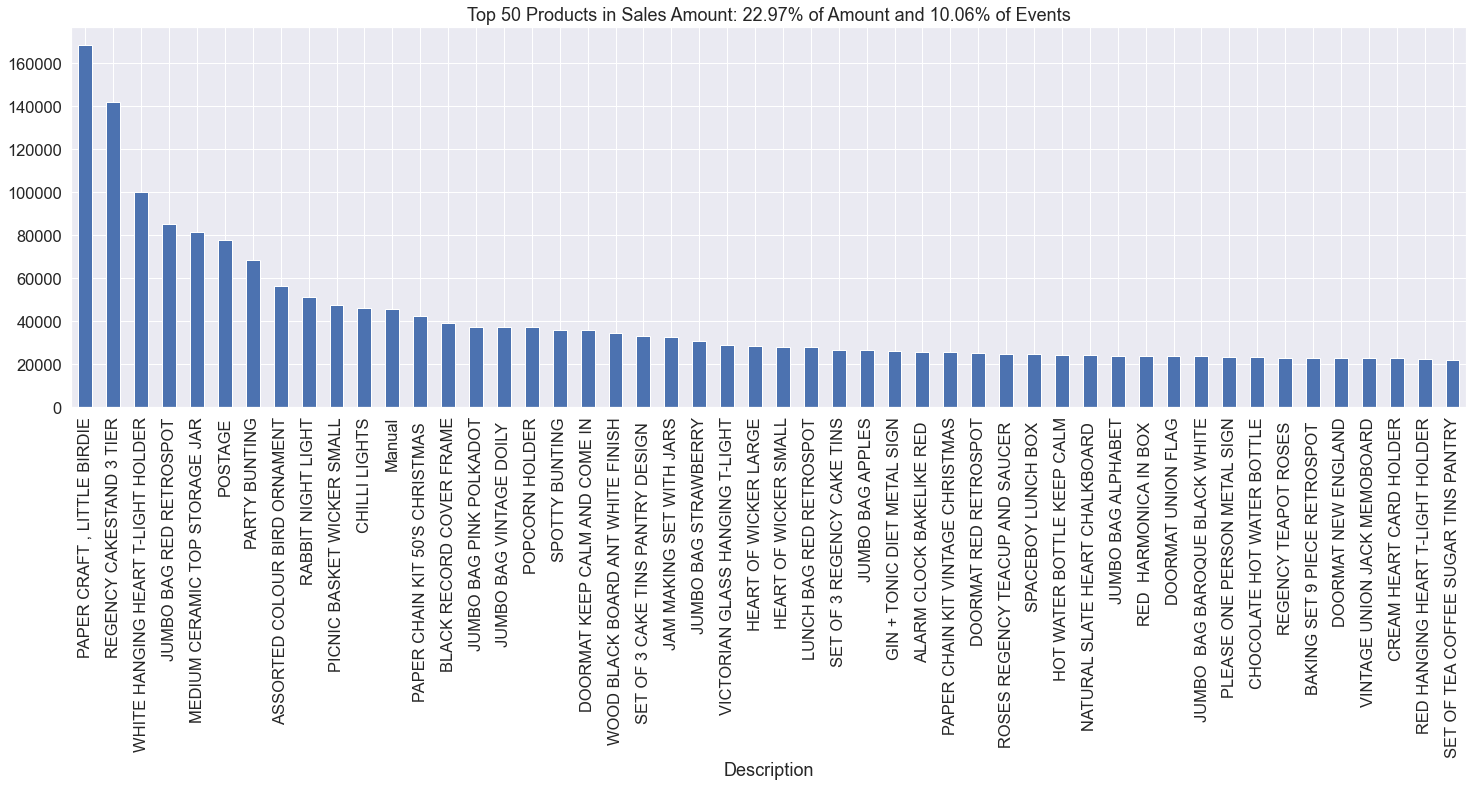

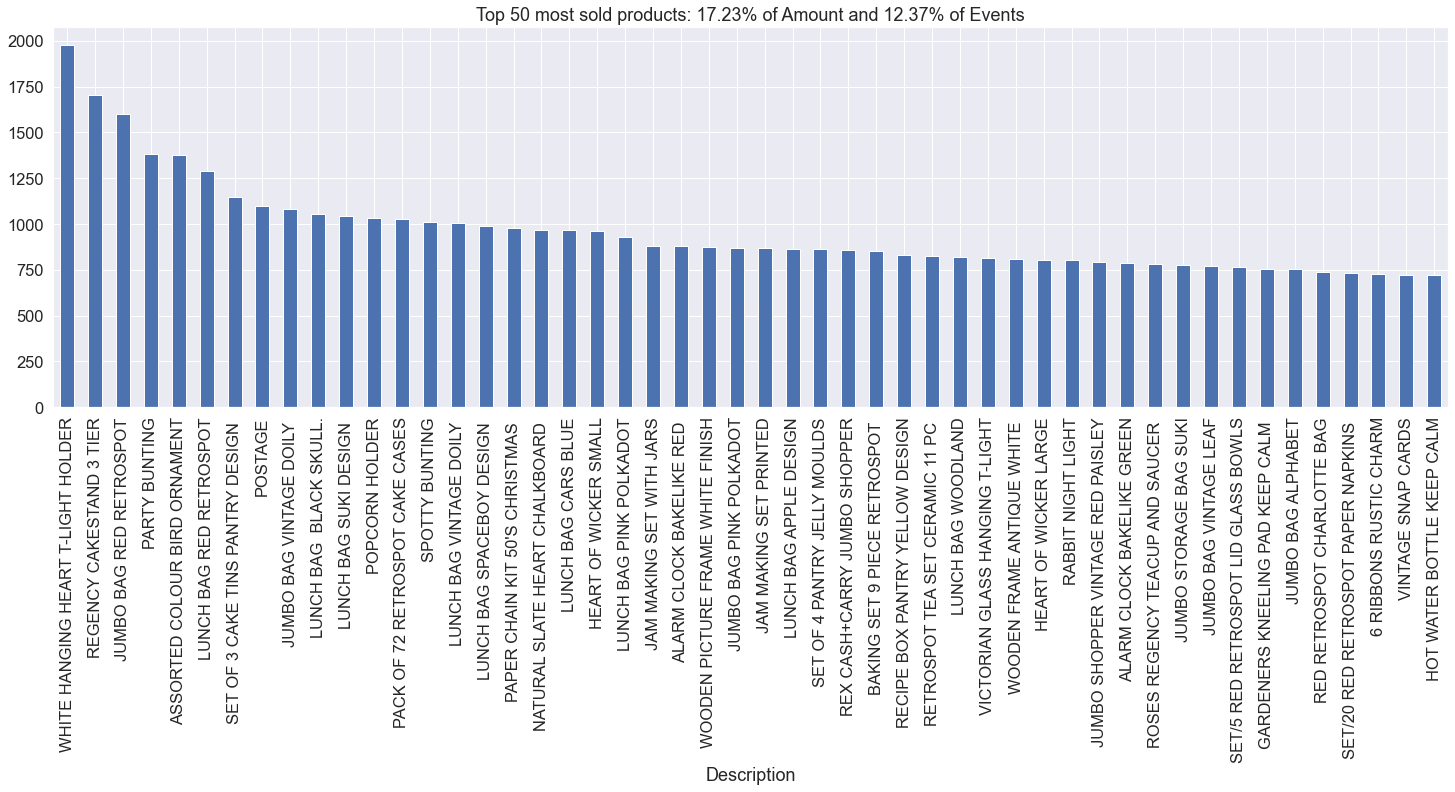

In [56]:
AmoutSum = df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

In [57]:
refrence_date =df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
df['days_since_last_purchase'] = (refrence_date - df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min      25%      50%  \
CustomerID  4339.0  15299.936852  1721.889758  12346.0  13812.5  15299.0   
recency     4339.0     92.518322   100.009747      1.0     18.0     51.0   

                75%      max  
CustomerID  16778.5  18287.0  
recency       142.0    374.0

We will plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


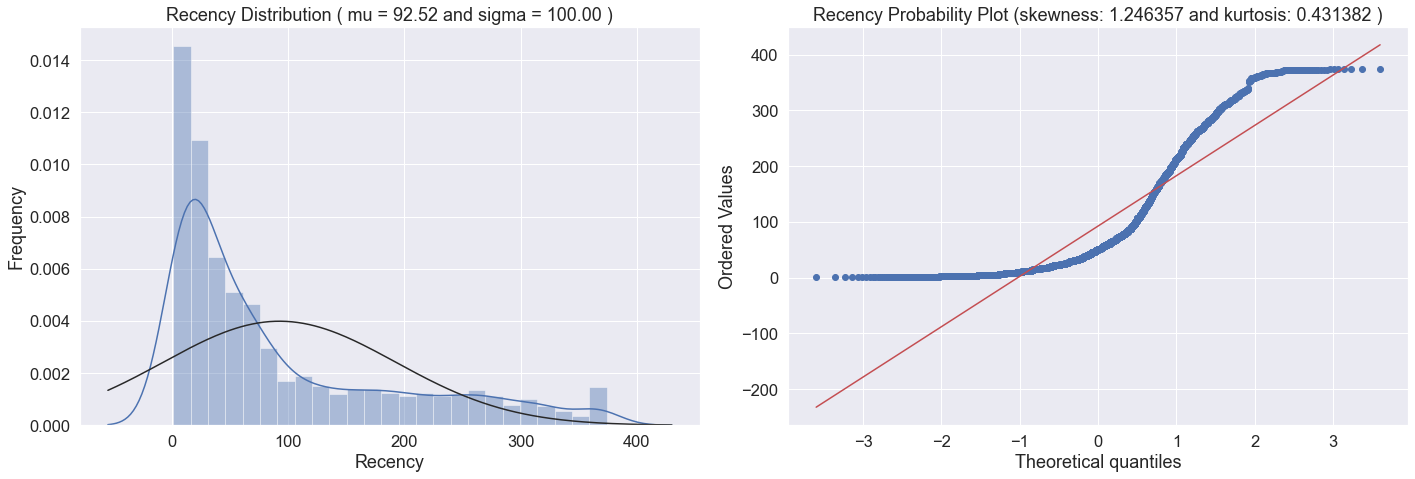

In [65]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


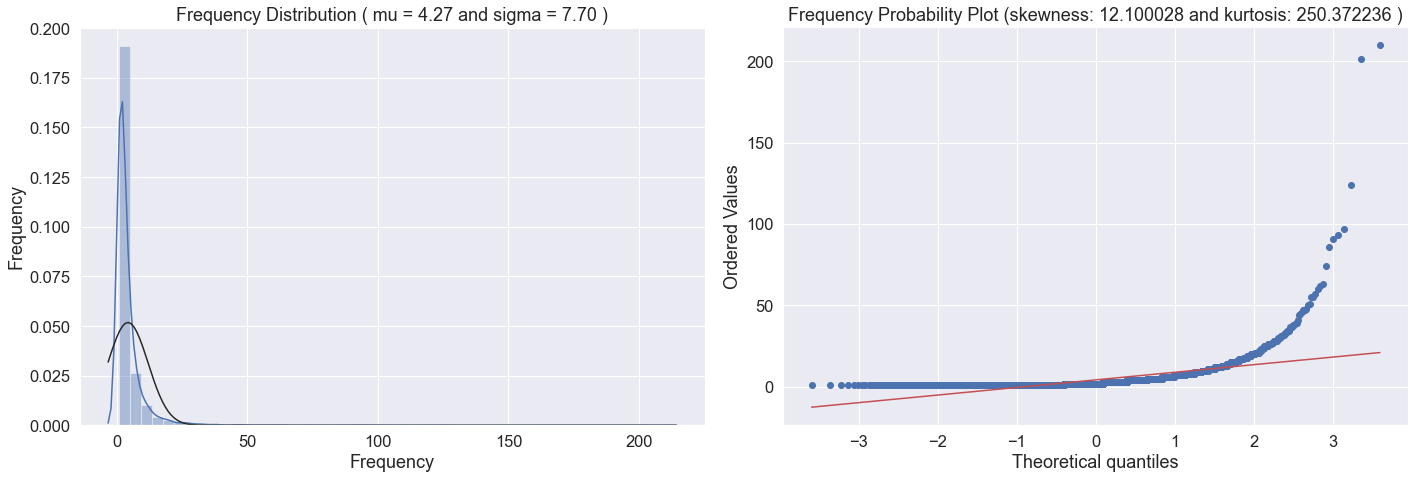

In [67]:
customer_freq = (df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

From the first graph above we can see that sales frequency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales frequency also does **not align with the diagonal and confirm that is a skewed right.**

With skewness positive of 12.1, we confirm the high lack of symmetry and with 249 Kurtosis indicates that is a heavy-tailed distribution and has outliers.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


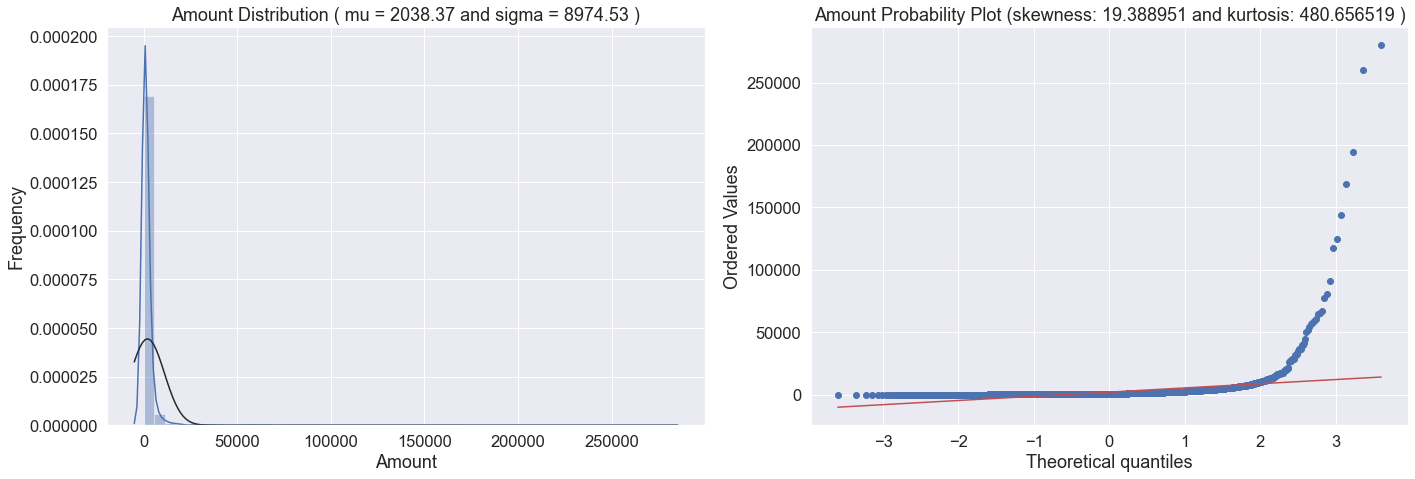

In [70]:
customer_monetary_val = df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

From the first graph above we can see that sales amount distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales amount also does not align with the diagonal, special on the right.

With skewness positive of 19.3, we confirm the high lack of symmetry and with 478 Kurtosis indicates that is a too heavy-tailed distribution and has outliers, surely more than 10 very extreme.

In [71]:
customer_history_df.describe()

CustomerID      recency    frequency         amount
count   4339.000000  4339.000000  4339.000000    4339.000000
mean   15299.936852    92.518322     4.271952    2038.370950
std     1721.889758   100.009747     7.705493    8975.562296
min    12346.000000     1.000000     1.000000       0.000000
25%    13812.500000    18.000000     1.000000     304.830000
50%    15299.000000    51.000000     2.000000     658.640000
75%    16778.500000   142.000000     5.000000    1647.690000
max    18287.000000   374.000000   210.000000  280206.020000

In [84]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(lambda x: math.log(x + 1e-8))
customer_history_df['amount_log'] = customer_history_df['amount'].apply(lambda x: math.log(x + 1e-8))
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std        min       25%       50%  \
amount_log     4339.0 -2.368851e-16  1.000115 -18.953439 -0.646508 -0.062256   
recency_log    4339.0 -2.477636e-16  1.000115  -2.630378 -0.612269  0.114893   
frequency_log  4339.0 -1.472600e-16  1.000115  -1.048362 -1.048362 -0.278846   

                    75%       max  
amount_log     0.633116  4.528122  
recency_log    0.829869  1.506044  
frequency_log  0.738399  4.887874

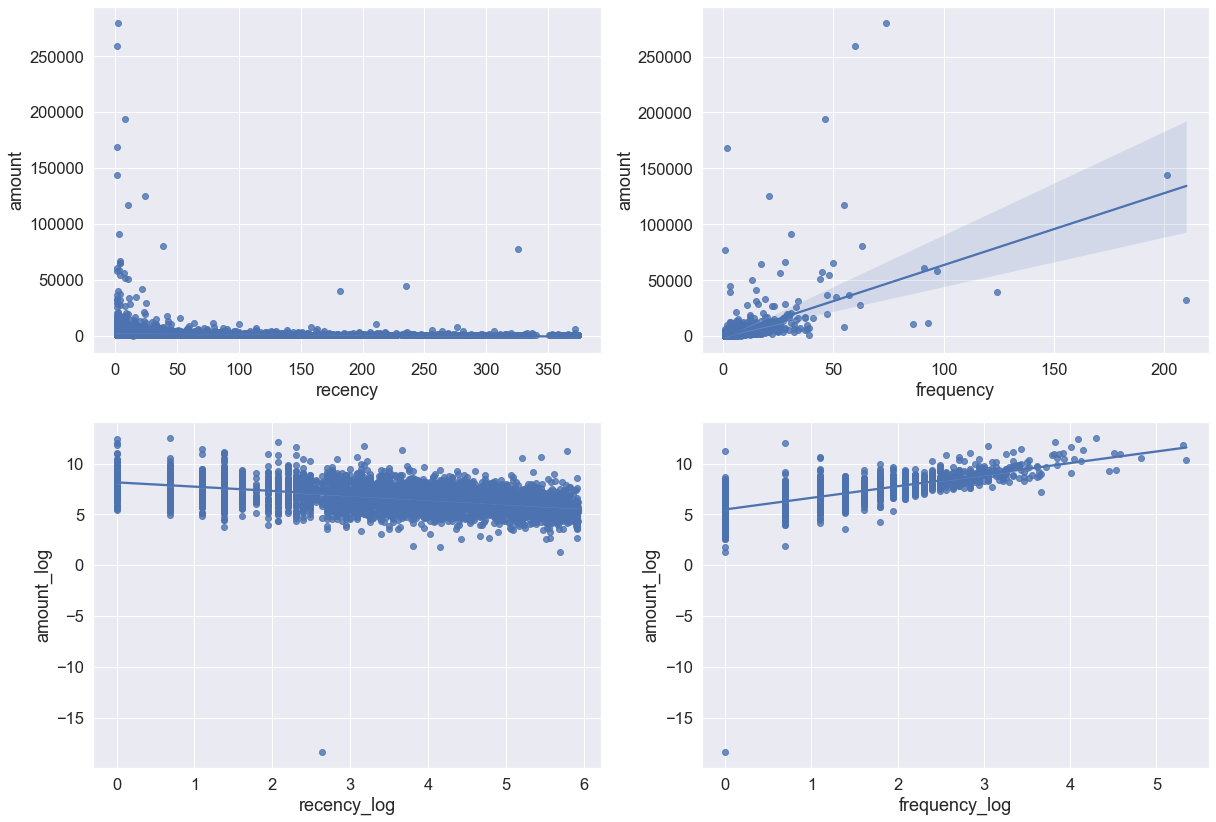

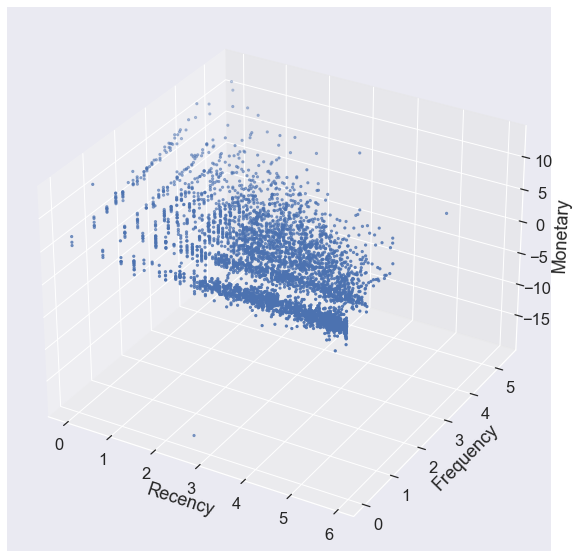

In [85]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

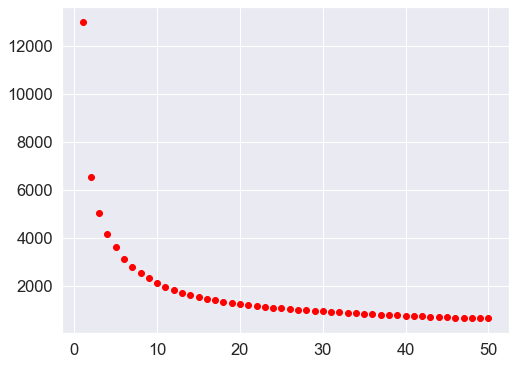

The best K sugest:  8


In [122]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)


# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()
# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

The best K sugest:  8


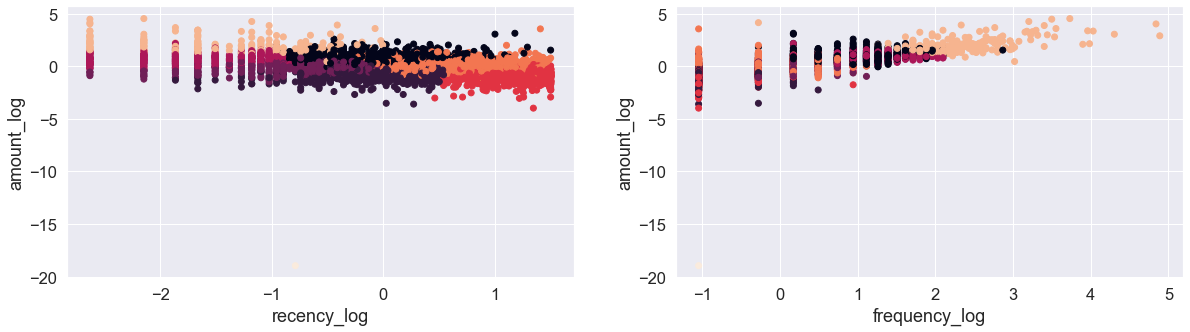

In [121]:
# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

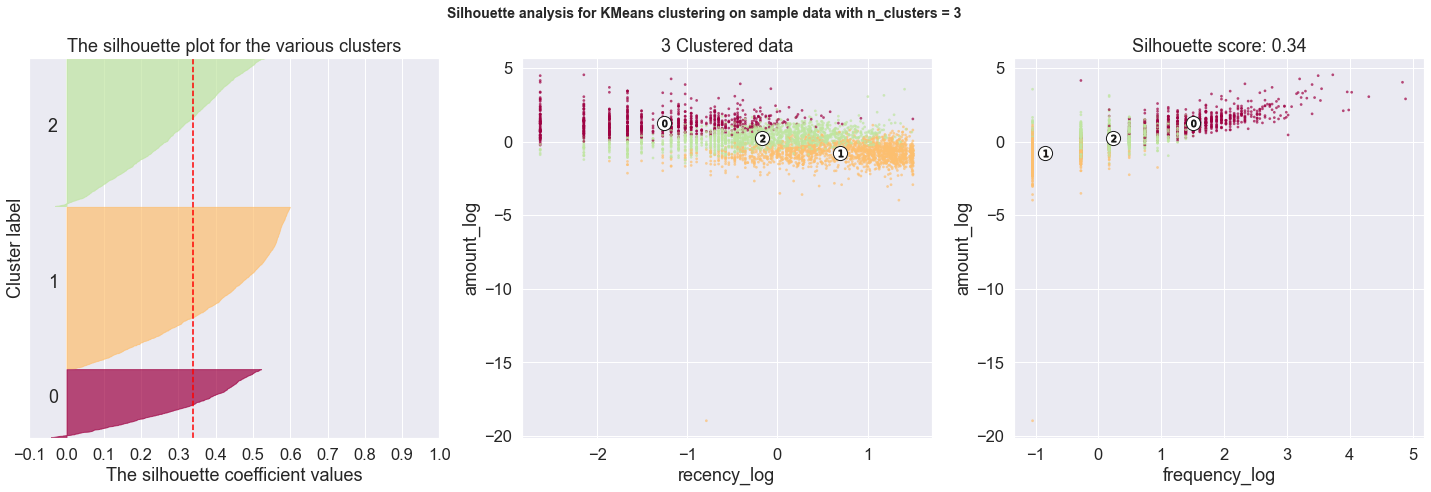

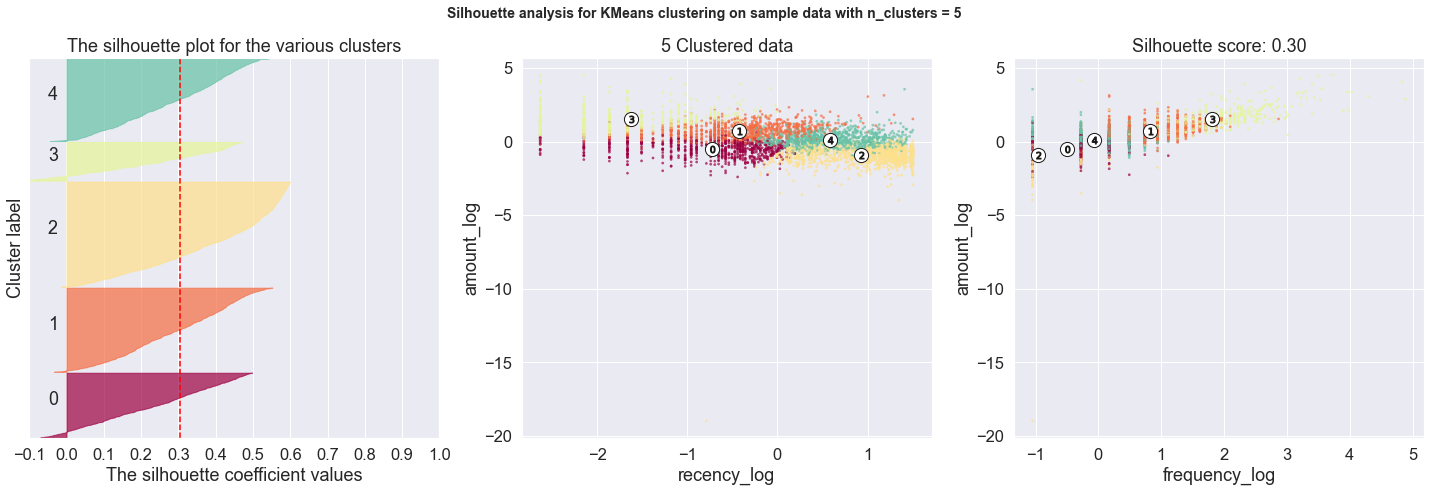

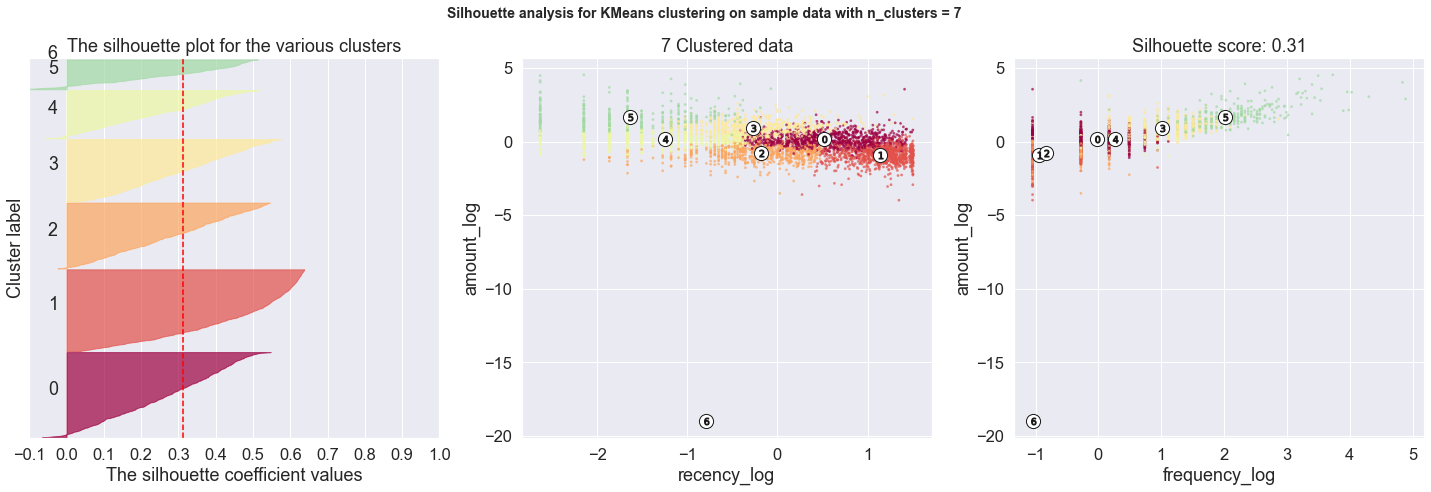

In [128]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [129]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0  3900.142098    7.104997  10.044173
1   258.206151  116.700573   1.189165
2   992.705987   33.745656   3.178421
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
        amount     recency  frequency
0   359.931286   15.301658   1.638939
1  1904.007203   23.410171   5.403509
2   208.457261  163.113509   1.081642
3  5235.802038    4.224302  13.005455
4   848.797091  100.354402   2.410045
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0  8.606560e+02   90.540171   2.502948
1  2.152618e+02  220.574331   1.095253
2  2.540714e+02   33.267946   1.209190
3  2.467676e+03   29.339621   6.386817
4  8.744966e+02    7.280330   3.276271
5  6.612693e+03    4.138138  15.688853
6  1.000000e-08   14.000000   1.000000

CustomerID  recency  frequency    amount  recency_log  frequency_log  \
0       12346    326.0          1  77183.60     5.786897       0.000000   
1       12347      2.0          7   4310.00     0.693147       1.945910   
2       12348     75.0          4   1595.64     4.317488       1.386294   
3       12349     19.0          1   1757.55     2.944439       0.000000   
4       12350    310.0          1    334.40     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.253942           2           4           0  
1    8.368693           0           3           5  
2    7.375030           2           4           0  
3    7.471676           2           0           2  
4    5.812338           1           2           1

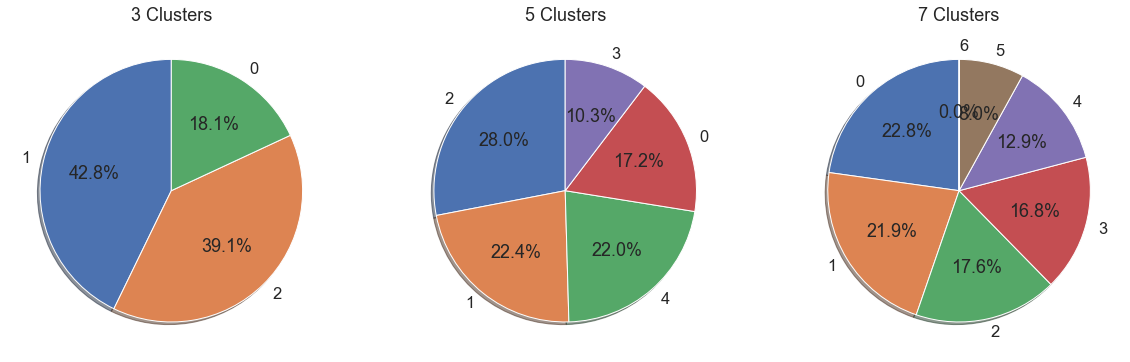

In [130]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

In [137]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if len(y0) > 0 and ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)


- After assigning labels to each customer based on their behavior, we can easily compare the summary of customers in each group.
- Visualizing this information can help us identify the differences in customer clusters, which we can use to modify our strategy accordingly.
- To avoid interference from extremely high outlier values of each group, we will only use data points that are less than the 0.95th percentile of the cluster.
- This approach will provide us with useful information about the majority of the users in that cluster segment.

# insights

There three significant cluster for this data set, 3,5, and 7. Some insights of this dataset is given bellow

***Three-cluster:***

- Clusters have good differences in monetary value of customers.
- Cluster 1 is high-value, frequent, and important.
- Clusters 0 and 2 are low and medium spenders.
- Frequency and Recency correlate with Monetary value.
- Box plots will confirm findings.

***Five-cluster:***

- Clusters 0 and 1 are similar to three-cluster.
- Cluster 1 is high-value and frequent.
- Cluster 2 has decent spend but is less frequent.Cluster 4 purchases medium amounts, less frequent and recent.
- Cluster 3 makes low-cost purchases, low frequency, but recent.
- Silhouette score suggests 5-cluster less optimal.
- Actions to increase frequency and loyalty.

***seven-cluster:***

 - Cluster 6 represents frequent and high-spending customers.
 - Clusters 1 and 5 have good spending and frequency, but differ in recency.
 - Cluster 0 has fourth best purchase, reasonable frequency, but hasn't purchased recently. 
 - Cluster 5 is similar to Cluster 0 but has made more recent purchases.



